# Predict Ship Crew Size
## Project Aims
We wish to build a linear model to predict crew size from the Ships data. We will use the following algorithms: 
- OLS Linear Regression
- Ridge Regression

We will build a simple OLS Linear Regression first and then we will use Pipelines and GridSearchCV to created an automated model selection process using nested cross validation. 

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

from category_encoders import TargetEncoder

import statsmodels.api as sm

## Setup

In [2]:
pd.options.plotting.backend = "plotly"
pd.options.display.max_rows = 24
pd.options.display.max_columns = 0

## Load Data

In [3]:
df = pd.read_csv('cruise_ship_info.csv')
df

Ship_name Cruise_line  Age  ...  cabins  passenger_density   crew
0        Journey     Azamara    6  ...    3.55              42.64   3.55
1          Quest     Azamara    6  ...    3.55              42.64   3.55
2    Celebration    Carnival   26  ...    7.43              31.80   6.70
3       Conquest    Carnival   11  ...   14.88              36.99  19.10
4        Destiny    Carnival   17  ...   13.21              38.36  10.00
..           ...         ...  ...  ...     ...                ...    ...
153       Taurus        Star   22  ...    0.33              50.62   0.59
154        Virgo        Star   14  ...    9.67              39.18  12.00
155       Spirit    Windstar   25  ...    0.74              33.86   0.88
156         Star    Windstar   27  ...    0.74              32.04   0.88
157         Surf    Windstar   23  ...    1.56              47.87   1.80

[158 rows x 9 columns]

## Summary Statistics

Below we calculate summary statistics for all columns in the data.

### Observations
- The 'crew' column contains floats as opposed to integers. Perhaps these are averages over a ships lifetime of voyages. 
- cabins has floats rather than integers - perhaps this is an average over its lifetime of voyages and is re-arranged. 
- Ship age median is 14 years and appears to have a relatively large outlier of 48 years. 
- Tonnage median is 71 and appears to have a relatively large outlier of 220


In [4]:
df.describe(include='all')

Ship_name      Cruise_line  ...  passenger_density        crew
count        158              158  ...         158.000000  158.000000
unique       138               20  ...                NaN         NaN
top       Spirit  Royal_Caribbean  ...                NaN         NaN
freq           4               23  ...                NaN         NaN
mean         NaN              NaN  ...          39.900949    7.794177
std          NaN              NaN  ...           8.639217    3.503487
min          NaN              NaN  ...          17.700000    0.590000
25%          NaN              NaN  ...          34.570000    5.480000
50%          NaN              NaN  ...          39.085000    8.150000
75%          NaN              NaN  ...          44.185000    9.990000
max          NaN              NaN  ...          71.430000   21.000000

[11 rows x 9 columns]

## Summary Histograms
Below, we produce histograms for each column (excluding the categorical / qualitative data): 

### Observations
- Tonnage has a large outlier
- Age has a series of old outliers
- Length has small variance i.e. probably poor predictor

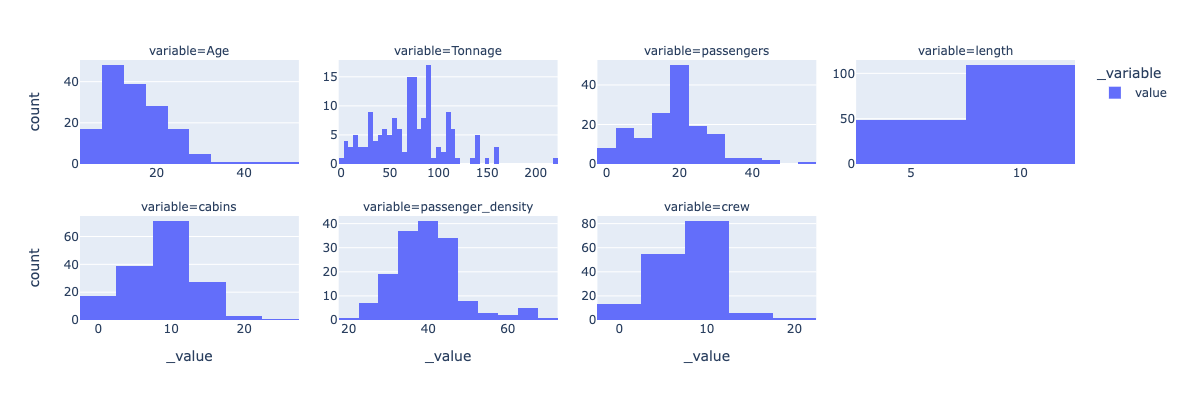

In [5]:
fig = df.loc[:,'Age':].melt().plot(kind='hist', facet_col = 'variable', 
                                   nbins = 50, facet_col_wrap = 4, 
                                   facet_col_spacing=0.04, 
                                   facet_row_spacing=0.2, width=800, 
                                   height=400)
# make each x and y axis independant and visible on each plot
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_yaxes(matches=None, showticklabels=True)

## Variable Selection
### Box Plot of Cruise Line
Below we plot a box plot of crew split via the Cruise_line, ordered by ascending median value. It looks like there are meaningful differences in median crew for different cruise lines, although some have quite large outliers and quite wide distributions. Cruise_line looks like a good candidate variable to use in our model. 

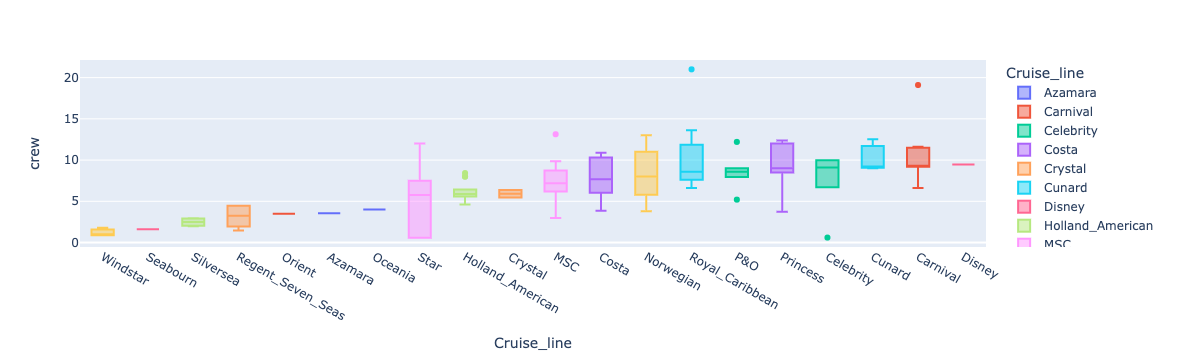

In [6]:
median_Cruise_lines = df.groupby('Cruise_line').median()['crew']
ascending_median_Cruise_lines = median_Cruise_lines.sort_values().index
fig = px.box(df, x="Cruise_line", y="crew", color = 'Cruise_line')
# Update axis to order by median crew size
fig.update_xaxes(categoryorder='array', 
                 categoryarray = ascending_median_Cruise_lines)
fig.show()

### Violin Plot of Cruise Line
Below we plot a violin plot of Cruise Line to see the data in a different way. 

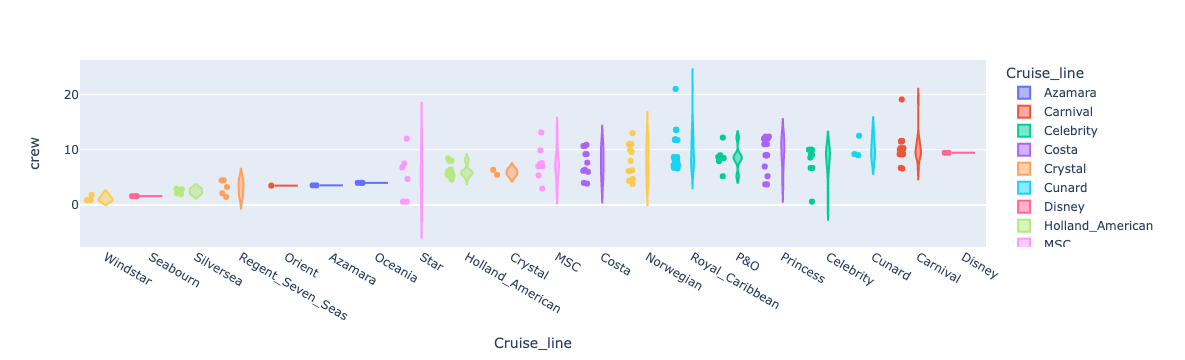

In [7]:
fig = px.violin(df, x="Cruise_line", y="crew", 
                points = 'all', color = 'Cruise_line')
fig.update_xaxes(categoryorder='array', 
                 categoryarray= ascending_median_Cruise_lines)
fig.show()

### Histogram of Cruise Line
Below we plot a histogram of crew size, split into different Cruise Lines, where each cruise line has been normalised i.e. sums to 1 on the histogram. This plot is a bit messy and hard to understand, although you can select different cruise line data to compare to make it more manageable. 


Below this we plot each histogram in a separate sub-plot, making it much easier to see and compare the various histograms simultaneously. From this plot, we conclude: 
- The categories are often quite sparse, with few observations in some categories. This means Target Encoding could over-fit the data and thus One Hot Encoding could be superior in this case. 
- There are 20 categories, which is quite a lot, although not too many such that One Hot Encoding would explode. 
- Different Cruise Lines do tend to have different typical crew sizes, often with little or no spread, making it a useful variable, although some cases such as 'Star' are fairly spread out with little concentration i.e. no obvious average crew size. 


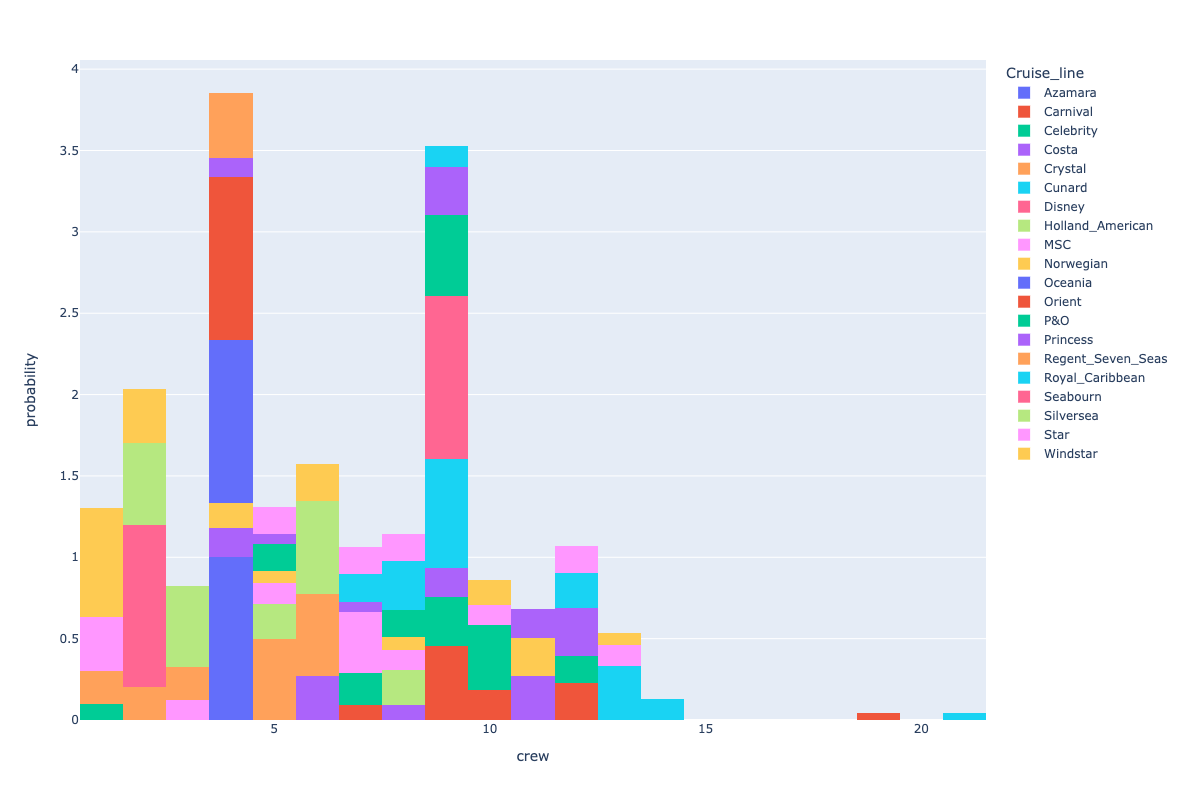

In [8]:
fig = px.histogram(df, x="crew", color = 'Cruise_line',
                   histnorm = 'probability', height =800)
fig.show()

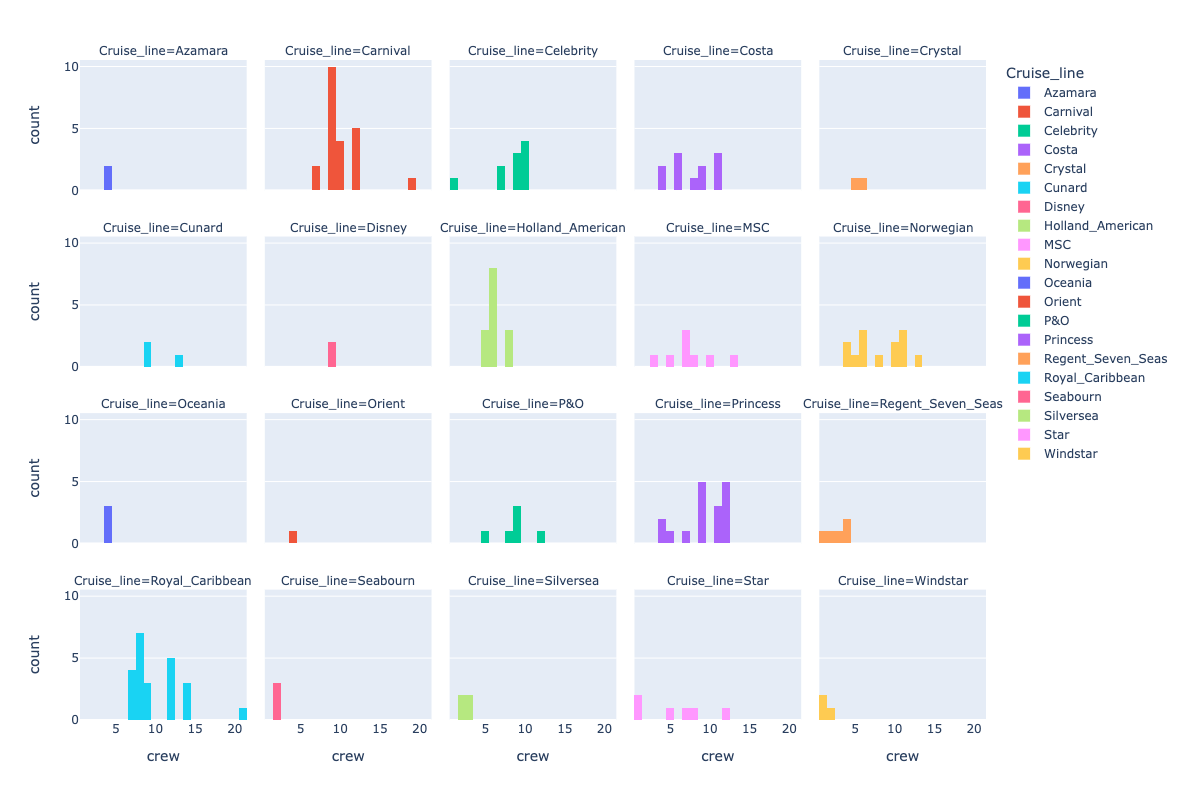

In [9]:
fig = px.histogram(df, x="crew", facet_col = 'Cruise_line', 
                   color = 'Cruise_line', height =800, facet_col_wrap = 5)
fig.show()

### KDE Plot Cruise Line
Finally, we wanted to do a quick KDE plot of Crew, split by Cruise Line. We found that the sparsity of certain Cruise Lines, combined with their identical crew numbers across all observations caused some issues. Some raise a 0 variance error we can ignore, and one ('Seaborn') actually causes an unavoidable singular matrix error, so we had to remove it to make the plot work.    

From the KDE plot, we can see the Cruise lines tend to peak at different crew sizes suggesting it would be a useful predictor. 

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<AxesSubplot:xlabel='crew', ylabel='Density'>

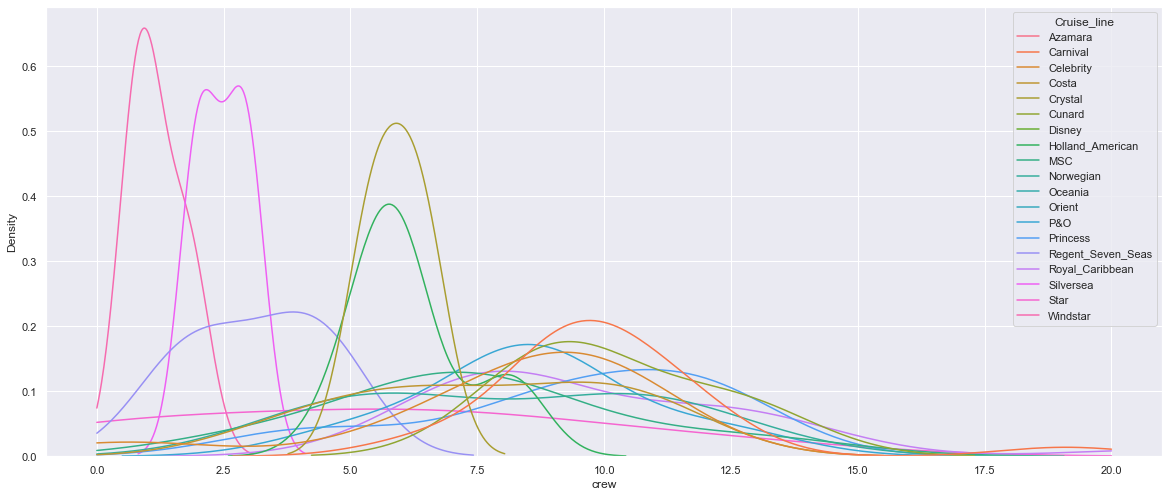

In [10]:
# Remove 'Seaborn' data from df  
df_clean = df[df.Cruise_line != 'Seabourn']
# set figure size
sns.set(rc={'figure.figsize':(20,8.27)})
sns.kdeplot(data=df_clean, x="crew",
            hue = 'Cruise_line', common_norm = False, 
           clip = (0,20))

### Scatter Plots and Correlation Matrix
Below we show pairwise scatter plots of all the numerical variables and a pairwise Pearson correlation matrix of all numerical variables. 

From the scatter plot, we can see that **Tonnage**, **Passengers**, **Length** and **Cabins** all have strong linear relationships with Crew. We can also see that all these variables are strongly correlated with one another, leading to multi-collinearity issues. From the correlation matrix, we can see the same correlations. 

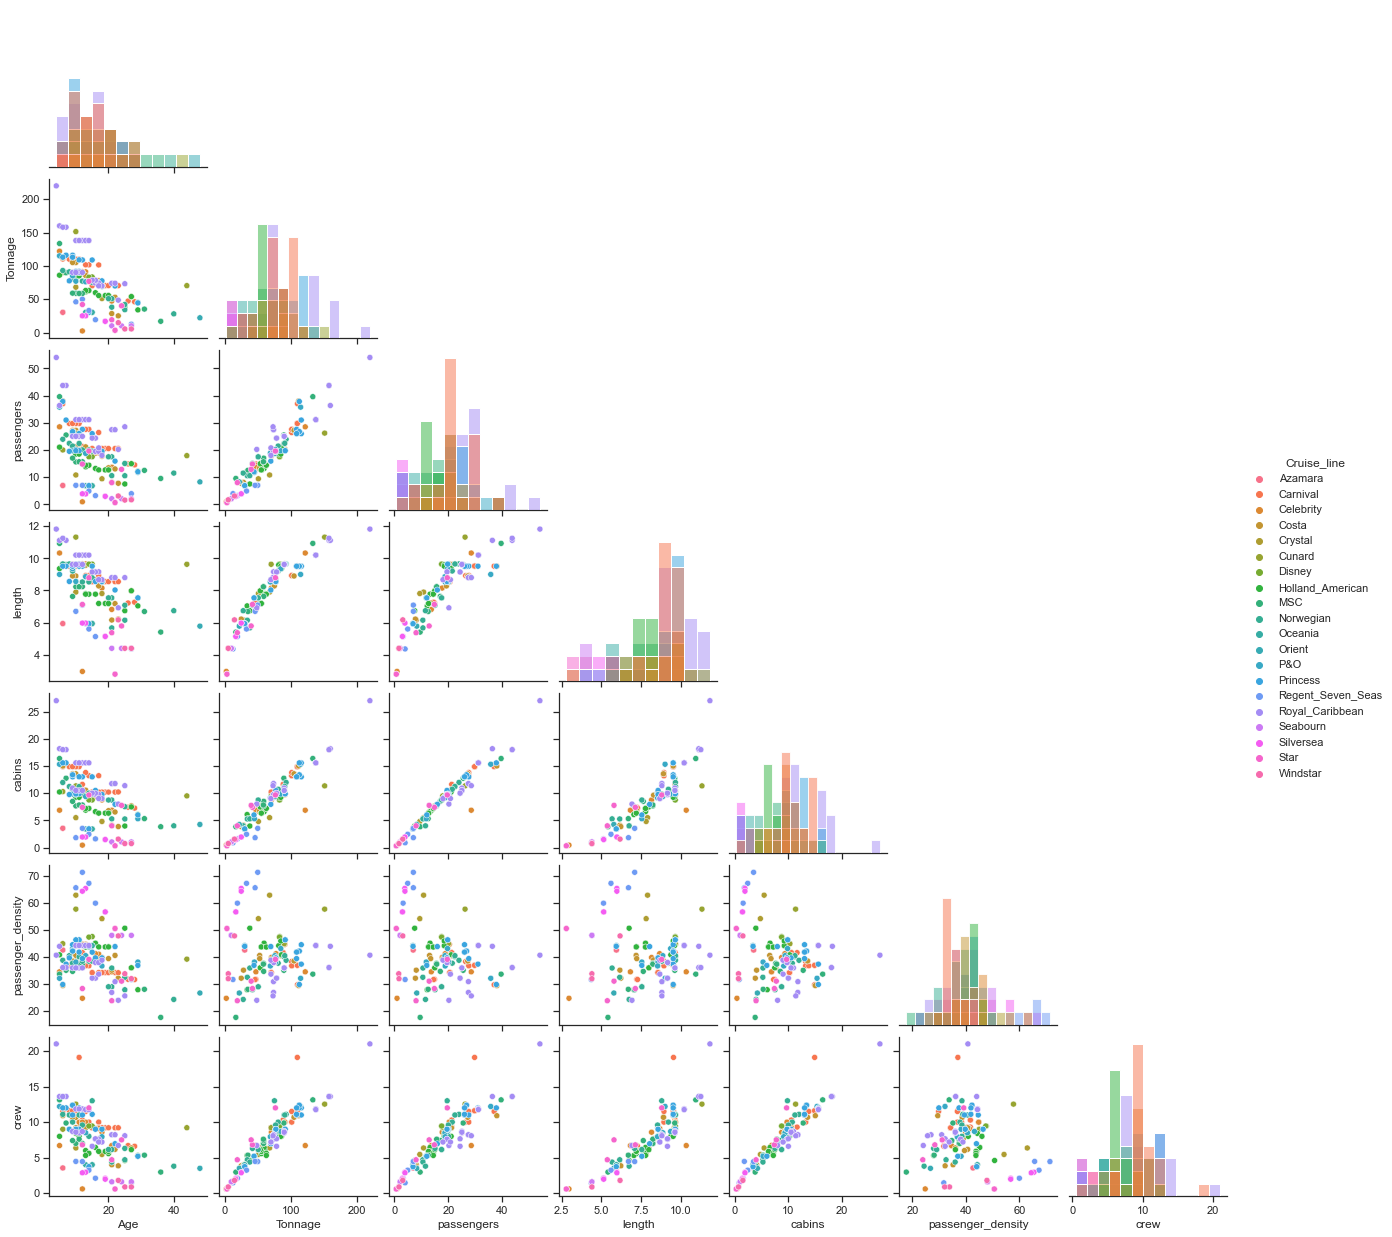

In [11]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue = 'Cruise_line', corner = True, diag_kind = 'hist')

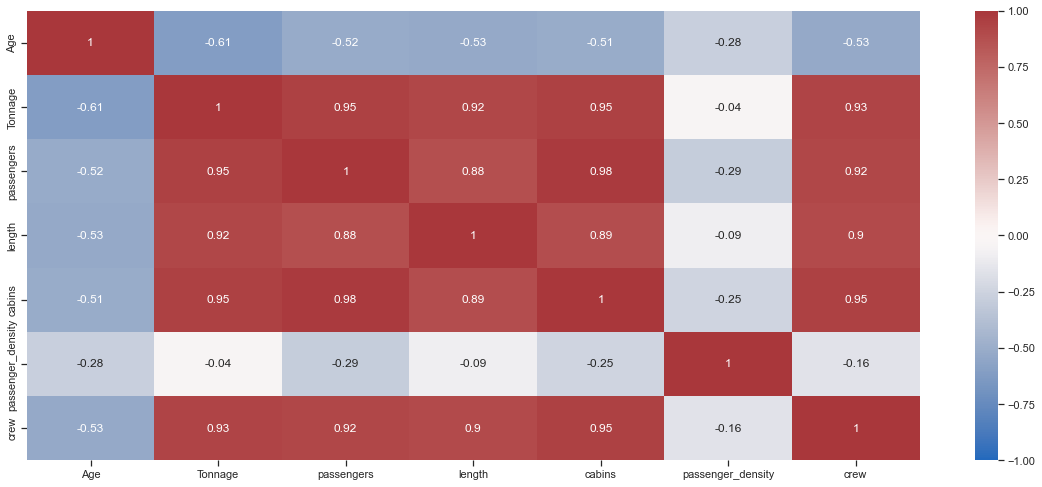

In [12]:
matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

## Variable Selection
The following variables will be dropped:
- **Age** -> low correlation with Crew size
- **passenger_density** -> low correlation with Crew size
- **Ship_name** -> No predictive value

The following variables will be used: 
- Cruise_line 
- Tonnage
- passengers
- length
- cabins

We need to deal with the multi-correlation issues between the following 4 variables: 
- Tonnage
- passengers
- length
- cabins

We will test 3 different approaches to address the multi-correlation:
1. Use cabins and drop the rest because cabins has the highest Pearson Correlation with crew size. 
2. Average the values of all variables together into a single master variable.
3. Use Ridge Regularization to auto-manage the multi-correlation. 

## Simple Model
As a learning exercise (to keep things simple and get used to basic scikit learn functions) we will build a simple OLS Linear Regression model without Pipelines or cross-validation. We will only use the 'Cruise_line' and 'cabins' data as predictors for this exercise. We will explore the results of this model and test some minor optimisations e.g. removing outliers. Following this, we will use Pipelines and cross-validation to make multiple different models using different predictors and different models e.g. regularised linear regression.
### Select Data

In [13]:
cabins_only = df[['Cruise_line', 'cabins']]

### Train Test Split Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(cabins_only, df['crew'], 
                                                    train_size=0.60, 
                                                    random_state=42)

### Encode Categorical Data
Below we One Hot Encode the Cruise_line variable in the **Training data**. 

In [15]:
enc = OneHotEncoder(drop='first', handle_unknown = 'ignore')
X_coded = enc.fit_transform(X_train['Cruise_line']
                            .values.reshape(-1,1))
# Drop old Cruise_line column from training data 
X_train.drop(columns=['Cruise_line'], inplace = True)
# Add One Hot Encoded data to training data (note enc.categories_[0] 
# gives us the column headers for encoded data, note that the first 
# entry is skipped because it was dropped to avoid dummy variable trap) 
X_train[enc.categories_[0][1:]] = X_coded.toarray()

We will also encode the **testing data** so it will be readily available to generate evaluation metrics once the model has been fitted. 

In [16]:
X_coded = enc.transform(X_test['Cruise_line']
                            .values.reshape(-1,1))
X_test.drop(columns=['Cruise_line'], inplace = True)
X_test[enc.categories_[0][1:]] = X_coded.toarray()

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



### Fit Model
Fit OLS Linear Regression model to training data. 

In [17]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Below we combine the coefficients and intercept of the model with their related variable name as a dictionary object. This allows us to easily inspect and understand the models coefficients. 

In [18]:
model = {'intercept':lm.intercept_}
for variable, coef in zip(X_train.columns, lm.coef_):
    model[variable] = coef
    
model

{'intercept': 0.7802339541104395,
 'cabins': 0.7802157875745238,
 'Carnival': 0.7063791118377352,
 'Celebrity': 1.0590313781194314,
 'Costa': -0.46621153428970924,
 'Crystal': 0.9247302655318416,
 'Cunard': 1.3703935568245835,
 'Disney': 1.8428779046124746,
 'Holland_American': -0.18449231478350386,
 'MSC': -0.23945934637983646,
 'Norwegian': 0.8998023789613934,
 'Oceania': 0.5514280523846874,
 'P&O': 0.376575728312926,
 'Princess': 0.1820643043917842,
 'Regent_Seven_Seas': 0.9297472473839071,
 'Royal_Caribbean': -1.0586331349353495,
 'Seabourn': 0.008341626812054383,
 'Silversea': 0.3055970491371233,
 'Star': 0.10879318515061065,
 'Windstar': -0.3374821098211445}

### Evaluate Model
We will now quantify various Evaluation metrics for the model:

In [19]:
R2_training = lm.score(X_train, y_train)

y_pred_training = lm.predict(X_train)
RMSE_training = mean_squared_error(y_train, 
                                   y_pred_training, 
                                   squared=False)

R2_test = lm.score(X_test, y_test)

y_pred_test = lm.predict(X_test)
RMSE_test = mean_squared_error(y_test, 
                                   y_pred_test, 
                                   squared=False)

print(f"R2 Training -> {R2_training}")
print(f"R2 Test -> {R2_test}")
print(f"RMSE Training -> {RMSE_training}")
print(f"RMSE Test -> {RMSE_test}")

R2 Training -> 0.9232899222987602
R2 Test -> 0.9349523870877381
RMSE Training -> 0.9480746140481218
RMSE Test -> 0.9065536306956056


In [20]:
mean_y = df.crew.mean()
nRMSE_test = RMSE_test / df.crew.mean() * 100

print(f"mean_y -> {mean_y}")
print(f"nRMSE_test -> {nRMSE_test}")

mean_y -> 7.794177215189873
nRMSE_test -> 11.63116523613097


We have a training and test R2 score of ~0.92 which seems pretty good for a first pass. The training R2 and RMSE scores are both worse than the test scores which seems unusual, but since its a very small difference and since the data has few samples, we assume this is simply down to random chance. 

The RMSE test score of ~0.9 seems pretty good compared to an average crew size of 7.8 meaning the error is around 11.6% of this average.   

### Residuals Plots
We will create a residuals plot of the target variable (crew size) against the difference between the predicted and actual crew size data. This will be done for the training data only (to help optimise the training).  

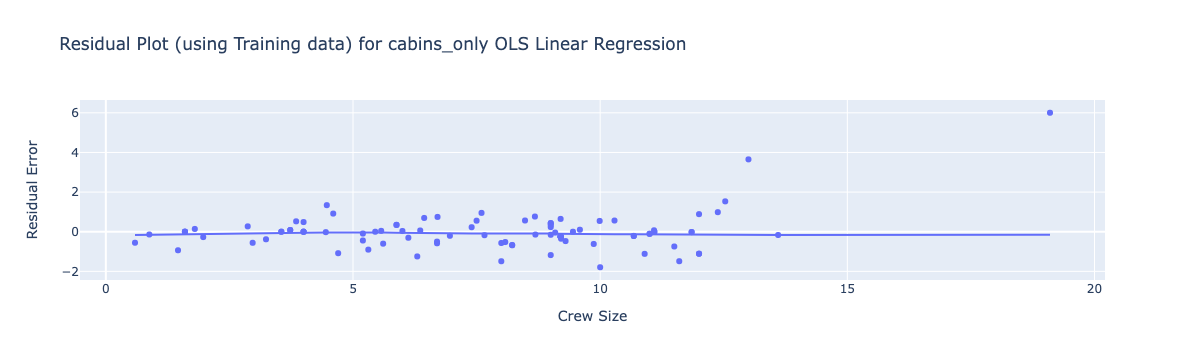

In [21]:
fig = px.scatter(x = y_train , y = y_train - y_pred_training, hover_name = y_train.index,
                 trendline = 'lowess',labels = {'y':'Residual Error', 
                                                'x':'Crew Size'}, 
                 title = "Residual Plot (using Training data) for cabins_only OLS Linear Regression")
fig.show()

Key observations: 
- The Residuals looks flat / linear suggesting the model is doing a good linear fit and isnt missing non-linear behaviour.
- There are 2 obvious potential outliers in points 3 and 83. 
- There may be a small amount of heteroscedasticity - the residuals do appear to funnel a small amount for increasing Crew size. 

### Q-Q plot of Residuals
Below we plot a Q-Q plot of the residuals (from training) to check whether the residuals are normally distributed.  

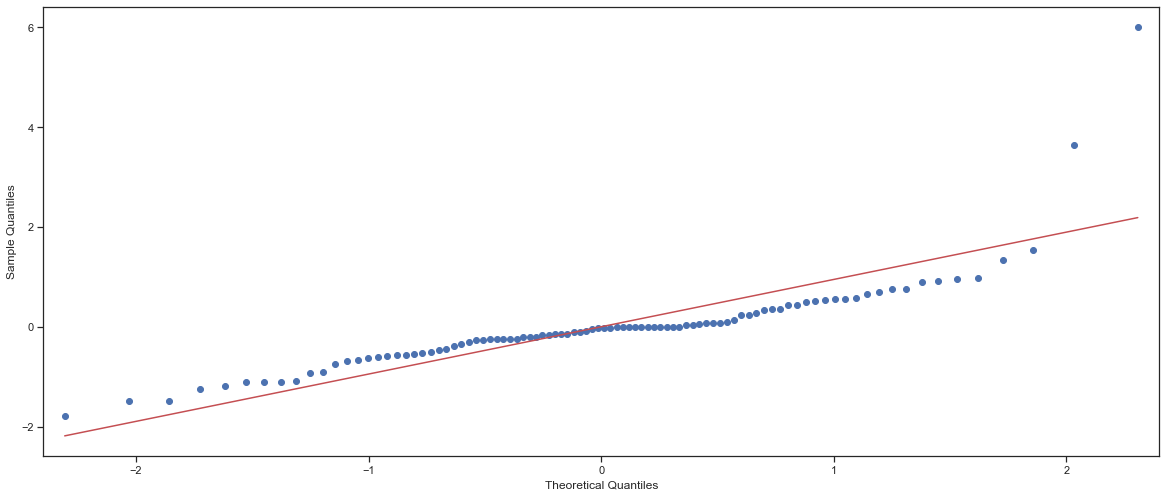

In [22]:
residuals = y_train - y_pred_training
fig = sm.qqplot(residuals, line = 's')
plt.show()

The outlying points 83 and 3 are skewing the results, so we will remove them. 

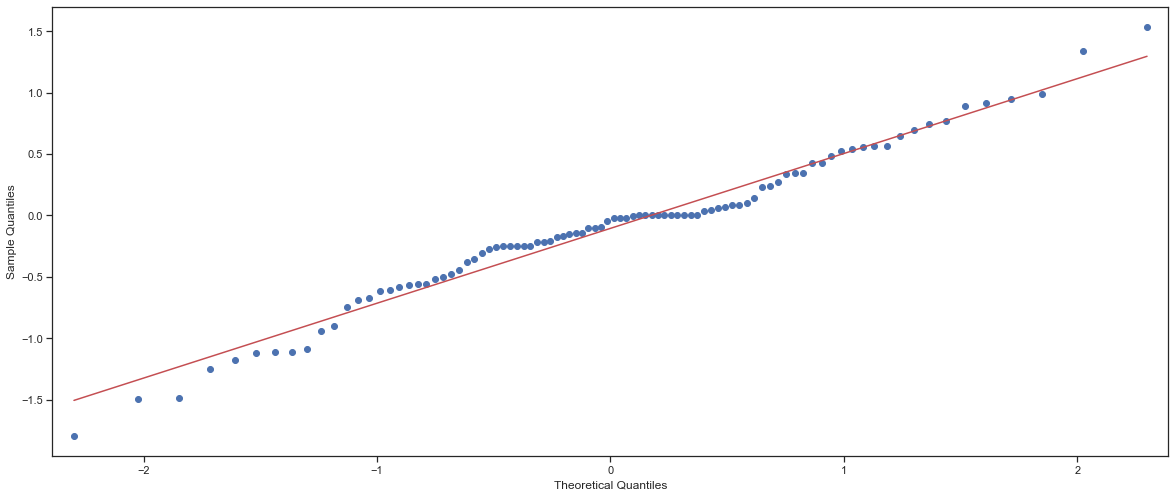

In [23]:
residuals_cleaned = residuals.sort_values()[:-2]
fig = sm.qqplot(residuals_cleaned , line = 's')
plt.show()

The Q-Q plot shows the residuals are not particularly normally distributed but for this number of samples and how close it is, we think its ok. 
## Tweak Simple Model
We are now going to remove the outlier points 3 and 83 from the training data and will re-train the model to see how it improves. 

In [24]:
# Drop outlier points from predictors and target data
X_train.drop([3,83], inplace = True)
y_train.drop([3,83], inplace = True)

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [25]:
model = {'intercept':lm.intercept_}
for variable, coef in zip(X_train.columns, lm.coef_):
    model[variable] = coef
    
model

{'intercept': 0.9365246141953891,
 'cabins': 0.7361902495224255,
 'Carnival': 0.5329540639626569,
 'Celebrity': 1.2838551257721498,
 'Costa': -0.19352835797952145,
 'Crystal': 0.9797621880969704,
 'Cunard': 1.6709412299269124,
 'Disney': 2.0718107024833903,
 'Holland_American': -0.03916401367352464,
 'MSC': -0.033529892141145295,
 'Norwegian': 0.4076278915808131,
 'Oceania': 0.5457047324379134,
 'P&O': 0.5855502822668842,
 'Princess': 0.48721998381022846,
 'Regent_Seven_Seas': 0.8691020687171421,
 'Royal_Caribbean': -0.6619630370859421,
 'Seabourn': -0.10216247369870878,
 'Silversea': 0.22459005912126445,
 'Star': 0.13058582648640063,
 'Windstar': -0.44314340114617834}

### Evaluate Model
We will now quantify various Evaluation metrics for the model:

In [26]:
R2_training = lm.score(X_train, y_train)

y_pred_training = lm.predict(X_train)
RMSE_training = mean_squared_error(y_train, 
                                   y_pred_training, 
                                   squared=False)

R2_test = lm.score(X_test, y_test)

y_pred_test = lm.predict(X_test)
RMSE_test = mean_squared_error(y_test, 
                                   y_pred_test, 
                                   squared=False)

print(f"R2 Training -> {R2_training}")
print(f"R2 Test -> {R2_test}")
print(f"RMSE Training -> {RMSE_training}")
print(f"RMSE Test -> {RMSE_test}")

R2 Training -> 0.9697316124152697
R2 Test -> 0.9444206571170497
RMSE Training -> 0.5544145240515543
RMSE Test -> 0.8379816789789729


In [27]:
mean_y = df.crew.mean()
nRMSE_test = RMSE_test / df.crew.mean() * 100

print(f"mean_y -> {mean_y}")
print(f"nRMSE_test -> {nRMSE_test}")

mean_y -> 7.794177215189873
nRMSE_test -> 10.751380881433537


Removing the outliers has improved our model, we now have an R2 score of 0.94 and a RMSE test of 0.84 which is ~10.75% of the mean crew size. 

### Residuals Plots
We will create a residuals plot of the target variable (crew size) against the difference between the predicted and actual crew size data.

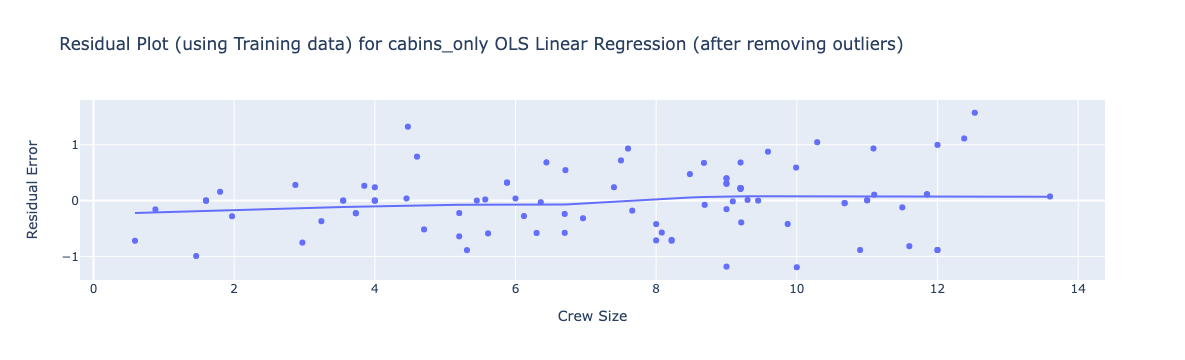

In [28]:
fig = px.scatter(x = y_train , y = y_train - y_pred_training, hover_name = y_train.index,
                 trendline = 'lowess',labels = {'y':'Residual Error', 
                                                'x':'Crew Size'}, 
                 title = "Residual Plot (using Training data) for cabins_only OLS Linear Regression (after removing outliers)")
fig.show()

Removing the outliers has improved the model. We could consider reviewing the residuals further, for example with Cook's distance and leverage, but decided that for the purposes of learning, it would be better to focus on building pipelines and other models first.

## Advanced Approach - Automated Testing of Multiple Models
We will now use pipelines, cross-validation and GridSearchCV to automate the training of multiple different models. We will test the following variations: 
- OLS Linear Regression and Ridge regression 
- Target Encoding and One Hot Encoding for 'Cruise_line'
- Dealing with the multi-collinearity by 3 different methods: 
  1. Using all multi-correlated variables in a Ridge Regression
  2. Using 'cabins' only
  3. Using an average of the 4 multi-correlated variables.  
  
### Nested Cross Validation
We will use a nested cross-validation to select the best model. We will use use GridSearchCV in the inner loop to select the best categorical encoding, data selection and to tune the hyperparamaters of the ridge regression. We will then compare the outer loop performance between the Ridge and OLS Linear models. 

### Create Averaged Variable 
We will add a column containing the average over the 'Tonnage', 'passengers', 'length' and 'cabins' columns. 

In [29]:
df['averaged'] = df[['Tonnage', 'passengers', 
                   'length', 'cabins']].mean(axis = 1)

### Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df[['Cruise_line','Tonnage', 'passengers',
                                                       'length', 'cabins', 
                                                       'averaged']], 
                                                    df['crew'], 
                                                    train_size=0.60, 
                                                    random_state=42)

In [31]:
X_train

Cruise_line  Tonnage  passengers  length  cabins  averaged
10            Carnival  110.000       29.74    9.51   14.87  41.03000
108           Princess   44.348       12.00    7.54    6.00  17.47200
104           Princess  108.806       26.00    9.51   13.00  39.32900
0              Azamara   30.277        6.94    5.94    3.55  11.67675
114  Regent_Seven_Seas   12.500        3.94    4.36    0.88   5.42000
..                 ...      ...         ...     ...     ...       ...
71                 MSC   59.058       17.00    7.63    8.50  23.04700
106           Princess   30.277        6.86    5.93    3.44  11.62675
14            Carnival   86.000       21.24    9.63   10.62  31.87250
92                 P&O   45.000       11.78    7.54    5.30  17.40500
102           Princess  113.000       37.82    9.51   15.57  43.97500

[94 rows x 6 columns]

### Custom Data Selector
Below we build a custom transformer that filters the data according to a list of column headers. This list of column headers can be used as a parameter in the GridSearchCV such that it can test different data selections within the grid search. 

In [32]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, columns):
        # save the features list internally in the class
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        # return the dataframe with the specified features
        return X[self.columns]

### Column Selectors
Below we create 3 different column selectors. These will be used in the Pipeline / GridSearchCV to select the specific columns used for each model using the above column selector.  

In [33]:
lasso_full = ['Tonnage', 'passengers', 'length', 'cabins']
cabins_only = ['cabins']
averaged_variables = ['averaged']

### Categorical Encoders
Below we build the 3 different categorical encoders that will be used to encode the 'Cruise_line' column. 

In [34]:
# for normal linear regression, we drop one column from the encoded columns 
# to avoid the dummy variable trap
ohe_not_reg = OneHotEncoder(drop='first', handle_unknown = 'ignore')
# For regularised (ridge) regression, we dont need to worry about dummy variable trap
ohe_reg = OneHotEncoder(handle_unknown = 'ignore')

# Target encoding, setting the defualt arguments to 0 (they apply smoothing that we don't 
# understand at this point, so we remove it so we understand exactly what its doing). 
target = TargetEncoder(min_samples_leaf = 0, smoothing = 0)

### Algorithms
Below we have the 2 different algorithms we are testing: 

In [35]:
lm = LinearRegression()
ridge = Ridge()

### Column Transformer
Below we create a column transformer that will encode the categorical data and select which numerical columns we want to use. By default it will use One Hot Encoding and will select 'cabins' as the numerical data. 

In [36]:
# categorical column
categ = ['Cruise_line']
# Numerical columns to select data from
num = ['Tonnage', 'passengers', 'length', 'cabins', 'averaged']

preprocessor = ColumnTransformer(
    [
        ('encode', ohe_not_reg, categ), 
        ('select_numerical_cols', ColumnsSelector(columns = ['cabins']), num)
    ]
)

### Pipeline (OLS Linear Regression) 
Below we build the pipeline for the OLS Linear Model. 

In [37]:
pipe_ols = Pipeline([('select_and_encode', preprocessor), ('model', lm)])

In [38]:
pipe_ols.fit(X_train, y_train)

Pipeline(steps=[('select_and_encode',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Cruise_line']),
                                                 ('select_numerical_cols',
                                                  ColumnsSelector(columns=['cabins']),
                                                  ['Tonnage', 'passengers',
                                                   'length', 'cabins',
                                                   'averaged'])])),
                ('model', LinearRegression())])

### Pipeline Parameters
Below we print the various parameters that can be accessed in the Pipeline and therefore accessed and varied by the Grid Search. 

In [39]:
pipe_ols.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'select_and_encode', 'model', 'select_and_encode__n_jobs', 'select_and_encode__remainder', 'select_and_encode__sparse_threshold', 'select_and_encode__transformer_weights', 'select_and_encode__transformers', 'select_and_encode__verbose', 'select_and_encode__verbose_feature_names_out', 'select_and_encode__encode', 'select_and_encode__select_numerical_cols', 'select_and_encode__encode__categories', 'select_and_encode__encode__drop', 'select_and_encode__encode__dtype', 'select_and_encode__encode__handle_unknown', 'select_and_encode__encode__sparse', 'select_and_encode__select_numerical_cols__columns', 'model__copy_X', 'model__fit_intercept', 'model__n_jobs', 'model__normalize', 'model__positive'])

We will use the *'select_and_encode__select_numerical_cols__columns'* parameter to vary which numerical data is selected.

In [40]:
pipe_ols.get_params()['select_and_encode__select_numerical_cols__columns']

['cabins']

We will use the *'select_and_encode__encode'* parameter to vary which encoder is used on the categorical data. 

In [41]:
pipe_ols.get_params()['select_and_encode__encode']

OneHotEncoder(drop='first', handle_unknown='ignore')

### Grid Search (OLS Linear Model)
For the purposes of learning and curiosity, before we perform the nested loop, we will perform a simple grid search cross-validation with 5 folds on the OLS Linear Model, varying the numerical data selected and categorical encoding used. Below we build and fit the grid search for the OLS Linear Regression pipeline. We will use 2 scorers in the grid search:
 1. RMSE -> this will be used to auto select the 'best' model
 2. R2 

Note that we will only be testing the 'cabins' and 'averaged' numerical data selections. We will test using all numerical columns together in the ridge / regularised model.  

In [42]:
columns_parameter = 'select_and_encode__select_numerical_cols__columns'
encoder_parameter = 'select_and_encode__encode' 

parameters = {columns_parameter:[cabins_only, averaged_variables], 
             encoder_parameter:[ohe_not_reg, target]}

grid_ols = GridSearchCV(estimator=pipe_ols, 
                    param_grid=parameters, 
                    scoring = ['neg_root_mean_squared_error', 'r2'], 
                    refit = 'neg_root_mean_squared_error')

In [43]:
grid_ols.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros

/opt/homebrew/Caskroom/miniforge/base/envs/ships/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



GridSearchCV(estimator=Pipeline(steps=[('select_and_encode',
                                        ColumnTransformer(transformers=[('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Cruise_line']),
                                                                        ('select_numerical_cols',
                                                                         ColumnsSelector(columns=['cabins']),
                                                                         ['Tonnage',
                                                                          'passengers',
                                                                          'length',
                                                                          'cabins',
  

### Grid Search Results (OLS Linear Regression)
Below we display and visualise the results of the grid search. 

In [44]:
results = pd.DataFrame(grid_ols.cv_results_)
results

mean_fit_time  std_fit_time  ...  std_test_r2  rank_test_r2
0       0.003836      0.000204  ...     0.097310             4
1       0.003379      0.000312  ...     0.077583             3
2       0.005560      0.000259  ...     0.058390             1
3       0.005026      0.000206  ...     0.081129             2

[4 rows x 23 columns]

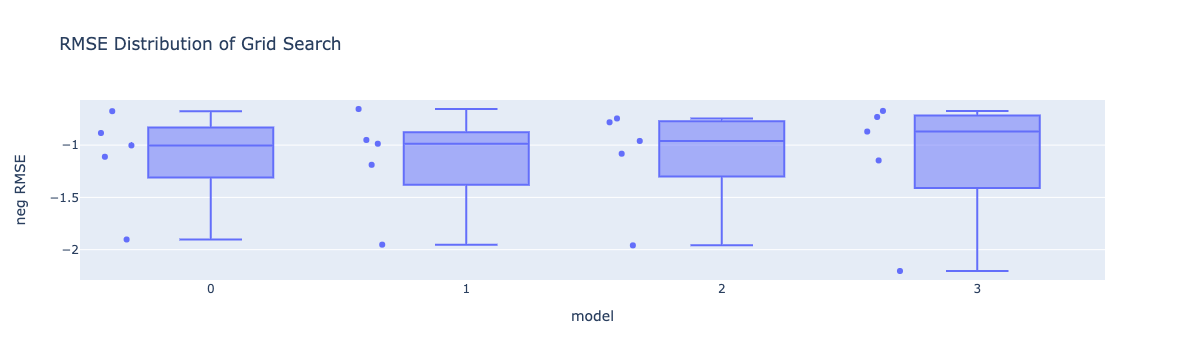

In [45]:
scores = results.T.loc['split0_test_neg_root_mean_squared_error'
                       :'split4_test_neg_root_mean_squared_error']
fig = px.box(scores, points = 'all', 
             title = 'RMSE Distribution of Grid Search', 
             labels = {'variable':'model', 'value':'neg RMSE'}, 
             hover_name = scores.index.values)
fig.show()

**Observations:** 
- All four models underperform significantly on the 3rd fold (split2), with the first 3 having similar performance on this fold and the final model under-performing a bit more. 
- Overall, all 4 models perform similarly, although given the note above the first 3 models all perform a bit better than the 4th.
- Models 0 and 2 look the best given their relatively small spread outside the under-performing fold (relatively consistent model score, with the score never dipping too low, although also not going as high as 1). These both use the cabins column as the numerical predictor. This suggests the 'averaged' column may have diluted the correlation with the target rather than incorporating more information. 

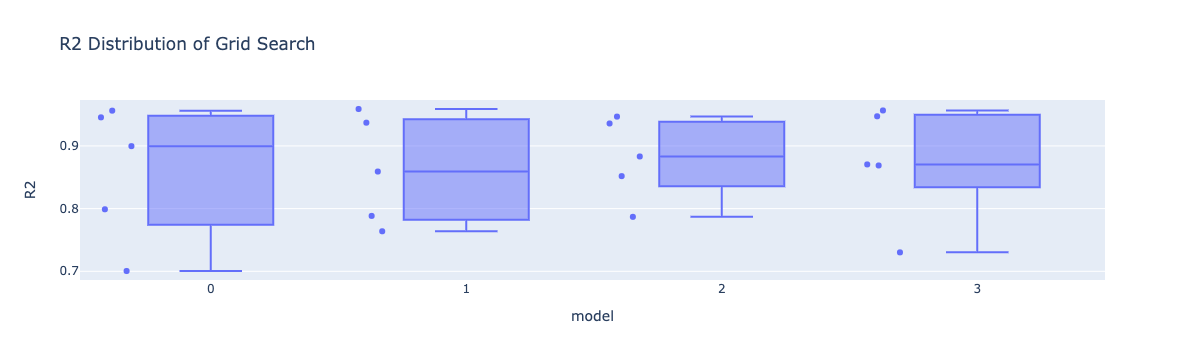

In [46]:
scores = results.T.loc['split0_test_r2':'split4_test_r2']
fig = px.box(scores, points = 'all', title = 'R2 Distribution of Grid Search',
             labels = {'variable':'model', 'value':'R2'}, 
             hover_name = scores.index.values)
fig.show()

**Observations:**
- Model 2 is the best performing according to R2 score. It has the lowest variance and is consistently quite good, although it doesn't get the highest scores and has a lower median than model 0. 
- Models 0 and 3 under-perform significantly on one fold relative to the other models.
- The consistent RMSE under-performance in the 3rd fold has not translated into a corresponding under-performance in R2 score, showing the different information gained from each scorer.  

**Conclusions**
- Overall best model looks like model 2 which is the Target Encoded model using the 'cabins' numerical column. 
- The grid search selected this preferred model automatically (based on minimum average RMSE score).  

### Pipeline (Ridge Regression)
Below we build the pipeline for the Ridge Regression Model. 

In [47]:
pipe_rr = Pipeline([('select_and_encode', preprocessor), ('model', ridge)])

In [48]:
pipe_rr.fit(X_train, y_train)

Pipeline(steps=[('select_and_encode',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Cruise_line']),
                                                 ('select_numerical_cols',
                                                  ColumnsSelector(columns=['cabins']),
                                                  ['Tonnage', 'passengers',
                                                   'length', 'cabins',
                                                   'averaged'])])),
                ('model', Ridge())])

### Grid Search (Ridge Regression)
We will repeat the simple grid search for the ridge regression. It will use 5 folds and varies the numerical data selected, categorical encoding used and alpha value for the ridge regression. We will test all 3 numerical column possibilities: 'cabins', 'averaged' and including all numerical columns (we called this 'lasso_full'). We will use 2 scorers in the grid search:
 1. RMSE -> this will be used to auto select the 'best' model
 2. R2  
 
 Note we use a different One Hot Encoder to the OLS Linear model. This One Hot Encoder will not drop a column after encoding the data, since this is not desirable when using regularisation.  

In [49]:
parameters = {columns_parameter : [cabins_only, averaged_variables, lasso_full], 
             encoder_parameter : [ohe_reg, target],
             'model__alpha' : [0.1, 1, 10, 100]}

grid_rr = GridSearchCV(estimator=pipe_rr, 
                    param_grid=parameters, 
                    scoring = ['neg_root_mean_squared_error', 'r2'], 
                    refit = 'neg_root_mean_squared_error')

In [50]:
grid_rr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('select_and_encode',
                                        ColumnTransformer(transformers=[('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Cruise_line']),
                                                                        ('select_numerical_cols',
                                                                         ColumnsSelector(columns=['cabins']),
                                                                         ['Tonnage',
                                                                          'passengers',
                                                                          'length',
                                                                          'cabins',
  

### Grid Search Results (Ridge Regression)
Below we show the results of the grid search.  

In [51]:
results = pd.DataFrame(grid_rr.cv_results_)
results

mean_fit_time  std_fit_time  ...  std_test_r2  rank_test_r2
0        0.002553      0.000400  ...     0.079495            22
1        0.002319      0.000203  ...     0.060332            11
2        0.002434      0.000239  ...     0.071707             3
3        0.005460      0.000651  ...     0.058389            15
4        0.004673      0.000162  ...     0.081133            21
5        0.004566      0.000094  ...     0.080058             7
6        0.002022      0.000071  ...     0.063717             9
7        0.002173      0.000261  ...     0.066531             8
8        0.002143      0.000126  ...     0.072984             2
9        0.005224      0.000197  ...     0.058380            16
10       0.005000      0.000342  ...     0.081171            20
11       0.004897      0.000179  ...     0.079679             5
12       0.002077      0.000154  ...     0.060014             4
13       0.002131      0.000255  ...     0.082976            12
14       0.002007      0.000130  ...     0.076260             1
15       0.005032      0.000288  ...     0.058314            17
16       0.005000      0.000357  ...     0.081535            19
17       0.004981      0.000329  ...     0.077523             6
18       0.002010      0.000199  ...     0.063262            10
19       0.001838      0.000035  ...     0.092765            24
20       0.002109      0.000148  ...     0.083892            14
21       0.004930      0.000308  ...     0.059053            23
22       0.004411      0.000075  ...     0.083985            18
23       0.004546      0.000093  ...     0.080424            13

[24 rows x 24 columns]

To understand these results better, we wanted to plot them as previously. However, due to the number of different models tested in the grid search, it was difficult to draw conclusions from the chart. You could not visually determine the parameters tested by each box plot. You would need to reference the 'results' table to understand what parameters were used by each boxplot. Given that we plotted 23 different models, this was a serious limitation. 

As such, we built a function that would extract the relevant scoring data from 'results' and format it in such a way that it could be easily plotted using plotly and would take advantage of plotly's interactive functionality as follows:  
- Hover the mouse over a data point to see: 
  - The specific fold that data point came from
  - The parameters of the model e.g. alpha = 0.6, encoding = OHE
- The models are labeled by their index in the results table, to make it easy to match a plot to a row in results. 
- Plots are ordered by std to get clearer insights from plot (can be easily changed to other aggregation e.g. mean or median)

Below we define our custom data formatting function and plot the results for the RMSE and r2 scorers:

In [52]:
def prep_plotting_data(results, scorer_name, n_folds):
    """Extract and format scorer data from GridSearchCV results for easy plotly plotting.
    
    Args:
        results (dataframe): The GridSearchCV cv_results_ attribute 
            after it has been converted to a pandas dataframe.
        scorer_name (string): Name of the scorer you wish to extract and 
            plot e.g. 'r2'.
        n_folds (int): The number of CV folds used by this GridSearchCV. 

    Returns:
        scores (dataframe): A dataframe with columns 'model', 'scorer_value'
            and 'params' that is easy to use with plotly. The index is the 
            fold of each scorer result e.g. 'split0_test_r2'.
    """
    # Extract parameter settings from grid search results and convert to
    # strings (they are stored as objects)  
    parameter_settings = [str(name) for name in results.params]
    parameter_settings_df = pd.DataFrame(parameter_settings, columns = ['params'])

    # Column headers of the first and last columns containing the scoring data
    # that we wish to extract
    first_split_header = 'split0_test_' + scorer_name
    last_split_header = 'split' + str(n_folds - 1) + '_test_' + scorer_name
    # Transpose results to make plotting easier and select just the scoring
    # data we want to plot.
    scores = results.T.loc[first_split_header
                           :last_split_header]

    # Melt the data to make plotting / hover data easier. After Transposing and
    # melting, the headers (which define which fold each set of data came from) 
    # have become the index and we have 2 columns. 'variable' column contains 
    # the index that each model had in the original results table. We can use
    # this number as a unique identifier for each model. Each model has 
    # multiple entries, a new row for each fold tested. The 'value' column 
    # contains the scorer value for that model on that fold.     
    scores = scores.melt(ignore_index=False)
    # rename the 'variable' column to 'model' (i.e. unique identifying number 
    # for each model) and rename 'value' to 'scorer_value'
    scores.rename(columns = {'variable' : 'model', 
                             'value' : 'scorer_value'}, 
                  inplace = True)
    # Add parameter settings to the scores data (join on 'model' which acts 
    # as a key mapping models between 'scores' and 'results' i.e. the index 
    # of a model in 'results' corresponds to the 'model' value in 'scores'.   
    scores = scores.join(parameter_settings_df, on = 'model')
    # Clean the paramater settings strings so it will be easy to 
    # read in the popup hover data
    scores['params'] = [clean_string(raw_string) for raw_string in scores.params]
    # Cast the 'model' column as strings (required for plotly to auto-plot
    # separate boxplots based on this column)
    scores['model'] = scores['model'].astype(str)
    return scores

def clean_string(raw_string):
    """Clean and format the 'params' text string from the GridSearchCV results.
    
    Args:
        raw_string (string): An entry from 'params' column of GridSearchCV 
            results that has been turned into a string. 

    Returns:
        cleaned_string (string): The cleaned string, including html formatting 
            to make it easier to read as a hover data in plotly charts.
    """
    
    # The 'params' string is a string that defines a dictionary, so here we
    # convert the string to a dictionary. 
    params = eval(raw_string)
    cleaned_string = ''
    # Loop through dictionary keys and form a easily read string, including 
    # a html new line <br> 
    for param_name, param_setting in params.items():
        cleaned_string += f"{param_name} = {param_setting}<br>"
    return cleaned_string

In [53]:
# Extract and format r2 scorer data for plotting
scores = prep_plotting_data(results, 'neg_root_mean_squared_error', 5)
scores.head(10)

model  ...                                             params
split0_test_neg_root_mean_squared_error     0  ...  model__alpha = 0.1<br>select_and_encode__encod...
split1_test_neg_root_mean_squared_error     0  ...  model__alpha = 0.1<br>select_and_encode__encod...
split2_test_neg_root_mean_squared_error     0  ...  model__alpha = 0.1<br>select_and_encode__encod...
split3_test_neg_root_mean_squared_error     0  ...  model__alpha = 0.1<br>select_and_encode__encod...
split4_test_neg_root_mean_squared_error     0  ...  model__alpha = 0.1<br>select_and_encode__encod...
split0_test_neg_root_mean_squared_error     1  ...  model__alpha = 0.1<br>select_and_encode__encod...
split1_test_neg_root_mean_squared_error     1  ...  model__alpha = 0.1<br>select_and_encode__encod...
split2_test_neg_root_mean_squared_error     1  ...  model__alpha = 0.1<br>select_and_encode__encod...
split3_test_neg_root_mean_squared_error     1  ...  model__alpha = 0.1<br>select_and_encode__encod...
split4_test_neg_root_mean_squared_error     1  ...  model__alpha = 0.1<br>select_and_encode__encod...

[10 rows x 3 columns]

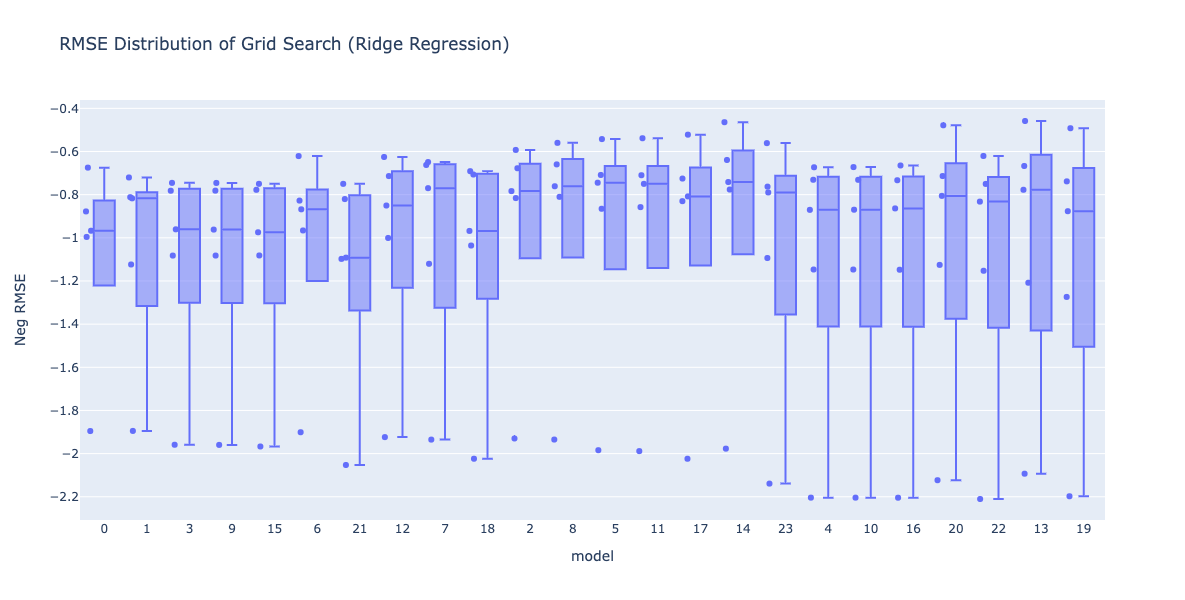

In [54]:
fig = px.box(scores, x = 'model', y = 'scorer_value', points = 'all', 
             title = 'RMSE Distribution of Grid Search (Ridge Regression)', 
             labels = {'scorer_value':'Neg RMSE'}, 
             hover_name = scores.index.values, hover_data=['params'], 
             height = 600)

# Order models on plot by their scorer std
order = scores.groupby('model')['scorer_value'].std().sort_values()
fig.update_xaxes(categoryorder ='array', 
                 categoryarray = order.index.values)
fig.update_layout(xaxis = dict(tickmode = 'array'))

fig.show()

**Observations:** 
- Best performing models are 2, 8, 5, 11, 17 and 14 -> they all generally have consistently high scores and low spreads. 
- These best performing models all use all 4 numerical columns, suggesting this is the best way to deal with multi-collinearity in this case. The regularisation is managing to extract more trend info from the 4 columns, unlike the 'averaged' column which seems to lose information.
- The worst performing models (the final 8, who have large score spreads) typically have an alpha = 100 or use the 'averaged' column. 
- The best alpha is probably between 0.1 and 10. 
- Like with the OLS linear regression, the 3rd fold (split 2) has a consistently poor score for all models. 

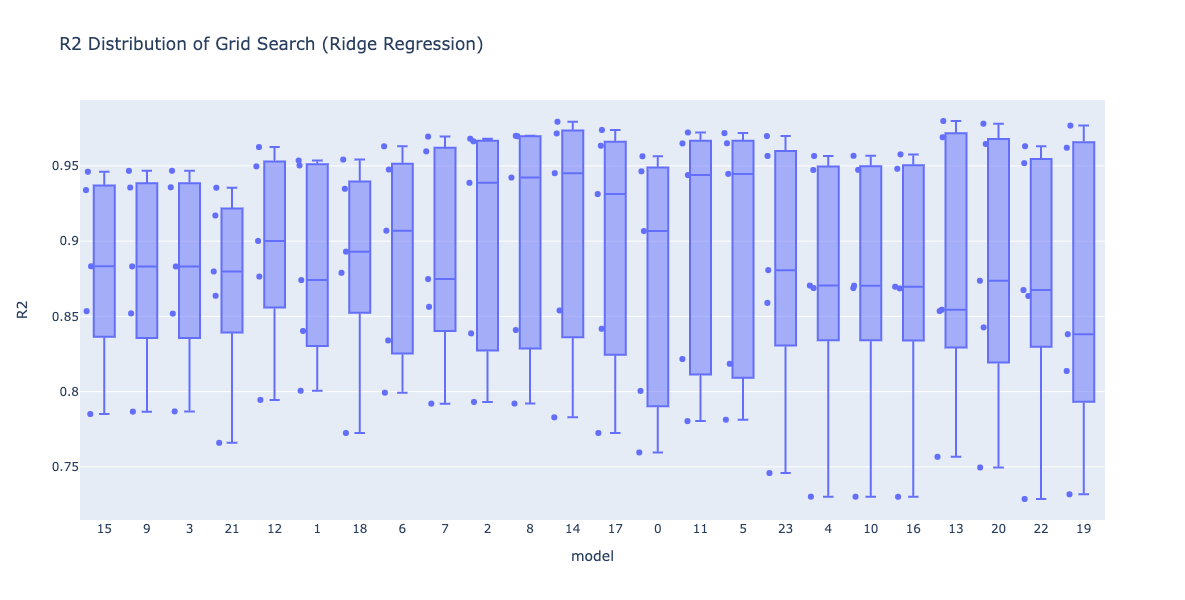

In [55]:
# Extract and format r2 scorer data for plotting
scores = prep_plotting_data(results, 'r2', 5)

fig = px.box(scores, x = 'model', y = 'scorer_value', points = 'all', 
       title = 'R2 Distribution of Grid Search (Ridge Regression)', 
       labels = {'scorer_value':'R2'},
       hover_name = scores.index.values, hover_data=['params'], 
       height = 600)

order = scores.groupby('model')['scorer_value'].std().sort_values()
fig.update_xaxes(categoryorder ='array', 
                 categoryarray = order.index.values)
fig.update_layout(xaxis = dict(tickmode = 'array'))

fig.show()

**Observations:**
- folds 2 and 3 (splits 1 and 2) had consistently under-performing scores.
- The R2 score is more consistently spread than the RMSE scores were (the best models stood out more with RMSE). In general, it can be hard to see clear conclusions from the plot. 
- Our favorite models are 2, 8 and 14 which have relatively high highest scores and their under-performing scores are not too low. These models are again associated with using all numerical data columns and have alpha values between 0.1 and 10. 
- Other interesting contenders are the first 3 models, which have a lower spread, but have similar lows to the above models but lack the highs. These models used the 'cabins' data only. 
- A final note, ideally we would have used adjusted R2 scores to avoid the risk of overfitting, but since this is a learning exercise and we have done a lot of new things, we decided to stick the scikit learns built in scorers.  

Below we show the top 5 models according to the grid search criteria (highest mean) using the RMSE scorer. We can see that based on the RMSE chart, we also chose these 5 as our top models, suggesting the grid search does a good job selecting the best model.  

In [56]:
results.sort_values('rank_test_neg_root_mean_squared_error')['params'].head(5)

14    {'model__alpha': 10, 'select_and_encode__encod...
8     {'model__alpha': 1, 'select_and_encode__encode...
2     {'model__alpha': 0.1, 'select_and_encode__enco...
11    {'model__alpha': 1, 'select_and_encode__encode...
5     {'model__alpha': 0.1, 'select_and_encode__enco...
Name: params, dtype: object

Below we show the top 5 models according to the grid search criteria (highest mean) using the R2 scorer. The top 3 models (14, 8 and 2) are the same 3 that we picked out as the best based on the R2 plot. Again, this suggests the grid search does a good job selecting the best model.  

In [57]:
results.sort_values('rank_test_r2')['params'].head(5)

14    {'model__alpha': 10, 'select_and_encode__encod...
8     {'model__alpha': 1, 'select_and_encode__encode...
2     {'model__alpha': 0.1, 'select_and_encode__enco...
12    {'model__alpha': 10, 'select_and_encode__encod...
11    {'model__alpha': 1, 'select_and_encode__encode...
Name: params, dtype: object

### Nested Cross Validation
We will now prepare the gridsearch objects to be used in a nested cross validation. We will use an inner loop of 2 folds and an outer loop of 5 folds. 

In [58]:
inner = KFold(n_splits = 2)
# Update gridsearch objects to use kfold with 2 splits  
grid_rr.set_params(cv = inner)
grid_ols.set_params(cv = inner)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('select_and_encode',
                                        ColumnTransformer(transformers=[('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Cruise_line']),
                                                                        ('select_numerical_cols',
                                                                         ColumnsSelector(columns=['cabins']),
                                                                         ['Tonnage',
                                                                          'passengers',
                                                                          'length',
                 

### Nested Cross Validatrion - OLS Regression
Below we perform the nested cross validation of the OLS Linear Regression: 

In [ ]:
ols_cross_val = cross_validate(grid_ols, X_train, y_train, 
                scoring = 'neg_root_mean_squared_error', 
                return_train_score = True, 
                return_estimator = True)

In [60]:
ols_cross_val_df = pd.DataFrame(ols_cross_val)
ols_cross_val_df

fit_time  score_time  ... test_score  train_score
0  0.054701    0.001749  ...  -0.884295    -0.986953
1  0.057479    0.001502  ...  -1.111596    -0.976495
2  0.060717    0.001306  ...  -1.958863    -0.830137
3  0.058988    0.001349  ...  -1.082298    -1.150842
4  0.051565    0.001196  ...  -0.745281    -1.220022

[5 rows x 5 columns]

In [61]:
mean_training_score = ols_cross_val_df.train_score.mean()
mean_test_score = ols_cross_val_df.test_score.mean()

print(f"mean training score -> {mean_training_score}")
print(f"mean test score -> {mean_test_score}")

mean training score -> -1.0328894915315554
mean test score -> -1.1564664261578408


In [62]:
crew_range = df.crew.max() - df.crew.min()
print(f"crew range -> {crew_range}")

crew range -> 20.41


We can see the OLS Linear Regression creates a decent model with a mean test score RMSE of 1.15 compared to a range of crew values of 20.41 which seems like a decent level of accuracy.
### Nested Cross Validation - Ridge Regression

In [63]:
rr_cross_val = cross_validate(grid_rr, X_train, y_train, 
                scoring = 'neg_root_mean_squared_error', 
                return_train_score = True, 
                return_estimator = True)

In [64]:
rr_cross_val_df = pd.DataFrame(rr_cross_val)
rr_cross_val_df

fit_time  score_time  ... test_score  train_score
0  0.274321    0.001251  ...  -0.659727    -0.971119
1  0.253654    0.001278  ...  -0.810074    -1.019524
2  0.257583    0.001606  ...  -1.934813    -0.576486
3  0.254694    0.001262  ...  -1.081737    -1.151162
4  0.255928    0.001307  ...  -0.559876    -0.973170

[5 rows x 5 columns]

In [65]:
mean_training_score_rr = rr_cross_val_df.train_score.mean()
mean_test_score_rr = rr_cross_val_df.test_score.mean()

print(f"Ridge mean training score -> {mean_training_score_rr}")
print(f"Ridge mean test score -> {mean_test_score_rr}")

Ridge mean training score -> -0.9382919431767528
Ridge mean test score -> -1.0092453931121075


In [66]:
crew_range = df.crew.max() - df.crew.min()
print(f"crew range -> {crew_range}")

crew range -> 20.41


The Ridge Regression Model has a RMSE of ~1, which is pretty decent and better than the OLS Linear Regression. It clearly makes the best model and generalises the best.  

In [67]:
for est in rr_cross_val_df.estimator:
    print(est.best_params_)

{'model__alpha': 1, 'select_and_encode__encode': OneHotEncoder(handle_unknown='ignore'), 'select_and_encode__select_numerical_cols__columns': ['Tonnage', 'passengers', 'length', 'cabins']}
{'model__alpha': 1, 'select_and_encode__encode': OneHotEncoder(handle_unknown='ignore'), 'select_and_encode__select_numerical_cols__columns': ['Tonnage', 'passengers', 'length', 'cabins']}
{'model__alpha': 1, 'select_and_encode__encode': OneHotEncoder(handle_unknown='ignore'), 'select_and_encode__select_numerical_cols__columns': ['Tonnage', 'passengers', 'length', 'cabins']}
{'model__alpha': 10, 'select_and_encode__encode': TargetEncoder(min_samples_leaf=0, smoothing=0), 'select_and_encode__select_numerical_cols__columns': ['cabins']}
{'model__alpha': 1, 'select_and_encode__encode': OneHotEncoder(handle_unknown='ignore'), 'select_and_encode__select_numerical_cols__columns': ['Tonnage', 'passengers', 'length', 'cabins']}


Out of curiosity, we have printed above the selected models from each inner loop tuning of the Ridge Regression. We can see that the alpha value is typically 1 and the encoder of choice is the One Hot Encoder. Perhaps the Target encoder tended to overfit because of the relatively high cardinality and low number of members of each Cruise Line. 

As we identified before, the model works best when including all 4 numerical columns. 

## Training Best Model
We have chosen the Ridge Regression Grid Search as the best model. We will now train it on the full set of training data. 

In [68]:
grid_rr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('select_and_encode',
                                        ColumnTransformer(transformers=[('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Cruise_line']),
                                                                        ('select_numerical_cols',
                                                                         ColumnsSelector(columns=['cabins']),
                                                                         ['Tonnage',
                                                                          'passengers',
                                                                          'length',
                 

## Test Set RMSE
Now we will test our final model on the test set to get an idea of how our model will perform on new data.  

In [69]:
pred_y = grid_rr.predict(X_test)
RMSE_test = mean_squared_error(y_test,
                               pred_y,
                               squared=False)
print(f"Test Error = {RMSE_test}")

Test Error = 0.8252818825871183


Our test set RMSE was 0.82, which seems a decent score and it looks like our model will perform quite well on new data. 

## Possible Improvements
- Use an Adjusted R2 Scoring
- Reviewing Residuals plots and dealing with outliers / high leverage points of the training set when using nested cross validation. 
- Review the equation estimated by the Ridge model to understand what drives crew size (would need to standardise the features first)